# 0.0 Importando Bibliotecas

In [119]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime

from matplotlib import pyplot as plt
from IPython.display import Image
from scipy import stats as ss
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as mt
from sklearn.linear_model import LinearRegression, Lasso

## 0.1 Carregando Dataset

In [4]:
df_train_raw = pd.read_csv('C:/Users/dmjes/OneDrive/Escritorio/Data_Science_CDS/Data_Science_em_Produção/playground/train.csv', low_memory=False)
df_store_raw = pd.read_csv('C:/Users/dmjes/OneDrive/Escritorio/Data_Science_CDS/Data_Science_em_Produção/playground/store.csv', low_memory=False)

# merge 
df_raw = pd.merge(df_train_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

## 0.2 Helper Function

In [7]:
def cramer_v(x, y):
    cm= pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) ## Corr para reduzir o viés
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))
    
###################################################################################################
def ml_error(model_name, y, yhat):
    mae= mt.mean_absolute_error(y, yhat)
    mape= mt.mean_absolute_percentage_error(y, yhat)
    rmse= mt.root_mean_squared_error(y, yhat)

    return pd.DataFrame({
    'Model Name': model_name,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse
    }, index=[0])

# 1.0 Descrição dos Dados

In [9]:
df1= df_raw.copy()

In [10]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.1 Rename Columns

In [12]:
cols_old = df1.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions

In [14]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [16]:
df1['date'] = pd.to_datetime(df1['date'])

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [19]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [21]:
df1['competition_distance'].max()

75860.0

In [22]:
#competition_distance   
df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month 
df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week 
df1['promo2_since_week']= df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\409410766.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['promo_interval'].fillna(0, inplace=True)


In [23]:
df1.sample(5).T

,954854,811895,811685,809928,194031
store,85,961,751,109,22
day_of_week,1,4,4,5,6
date,2013-02-25 00:00:00,2013-07-04 00:00:00,2013-07-04 00:00:00,2013-07-05 00:00:00,2015-02-07 00:00:00
sales,5187,7413,5308,6703,3341
customers,812,732,616,750,369
open,1,1,1,1,1
promo,0,1,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,0
store_type,b,d,a,a,a


## 1.6 Change Types

In [25]:
change_type = ['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']
for i in change_type:
    df1[i] = df1[i].astype(int)

## 1.7 Descriptive Statistical

In [27]:
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [29]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

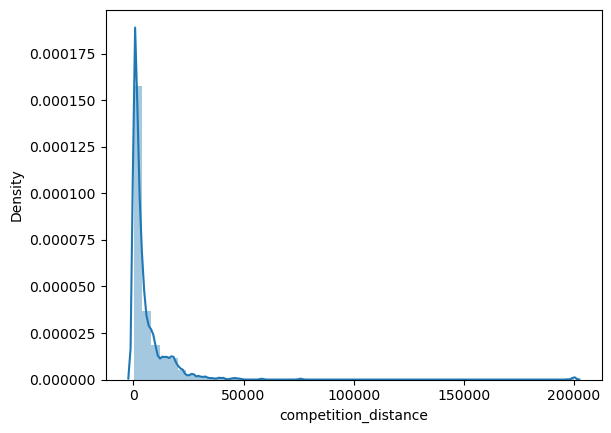

In [30]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [32]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\2797913433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=list[i], y='sales', data=aux1, palette= 'Set2')
C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\2797913433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=list[i], y='sales', data=aux1, palette= 'Set2')
C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\2797913433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=list[i], y='sales', data=aux1, palette= 'Set2')


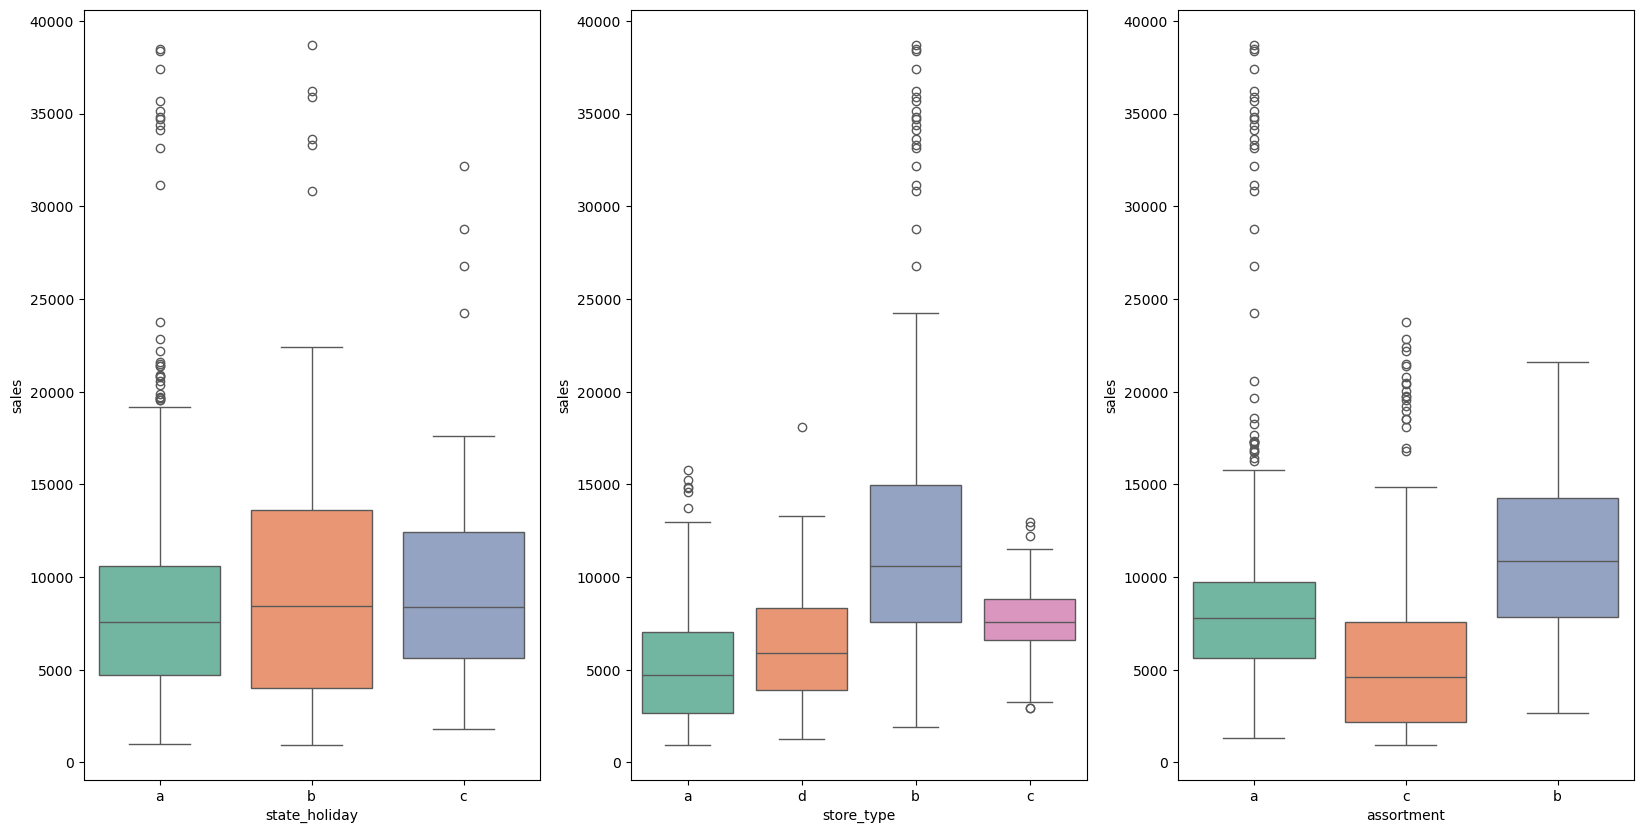

In [33]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] != 0)]
list = ['state_holiday', 'store_type', 'assortment']
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=list[i], y='sales', data=aux1, palette= 'Set2')

# 2.0 Feature Engineering

## 2.1 Mapa Mental de Hipóteses

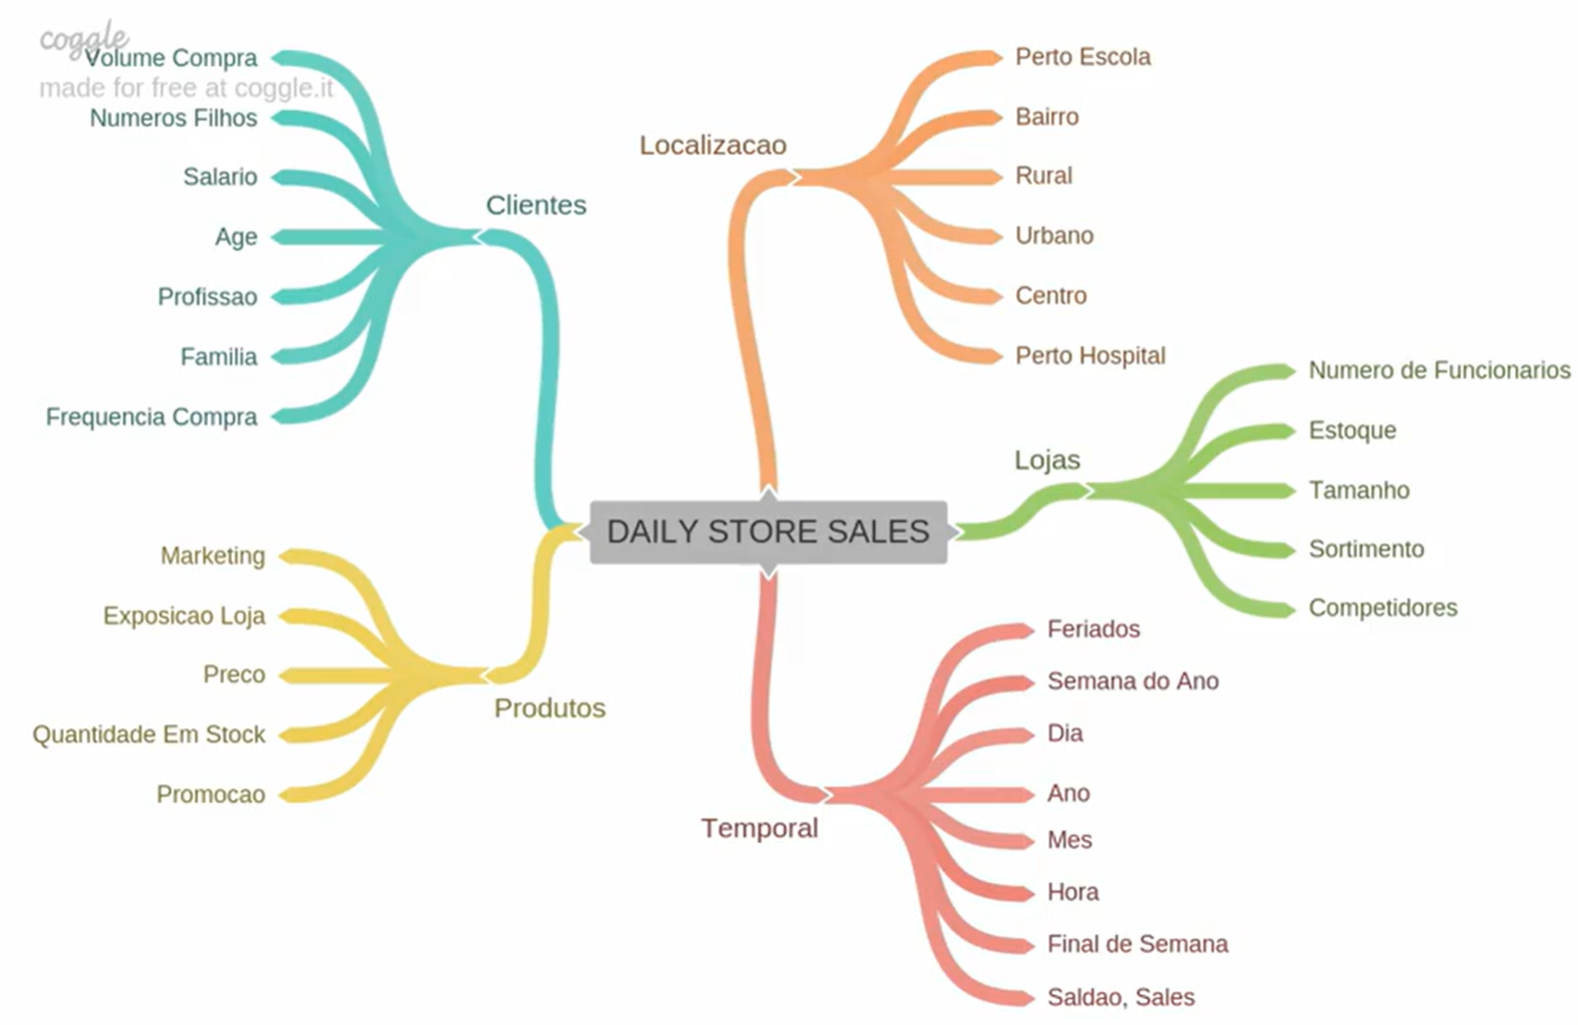

In [36]:
image_path = ('img/MindMapHypothesis.png')
Image(image_path)

## 2.2 Criação de hipóteses

In [38]:
df2 = df1.copy()

### 2.2.1 Hipóteses Lojas

 **1.** Lojas com número maior de funcionários deveriam vender mais.
 
 **2.** Lojas com maior capacidade de estoque deveriam vender mais.
 
 **3.** Lojas com maior porte deveriam vender mais.
 
 **4.** Lojas com maior sortimentos deveriam vender mais.
 
 **5.** Lojas com competidores mais próximos deveriam vender menos.
 
 **6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses Produtos

 **1.** Lojas que investem mais em Marketing deveriam vender mais.
     
 **2.** Lojas com maior exposição de produto deveriam vender mais.
     
 **3.** Lojas com produtos com preço menor deveriam vender mais.
     
 **5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
     
 **6.** Lojas com promoções ativas por mais tempo deveriam vender mais.
     
 **7.** Lojas com mais dias de promoção deveriam vender mais.
     
 **8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

 **1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

 **2.** Lojas deveriam vender mais ao longo dos anos.

 **3.** Lojas deveriam vender mais no segundo semestre do ano.
     
 **4.** Lojas deveriam vender mais depois do dia 10 de cada mês.
     
 **5.** Lojas deveriam vender menos aos finais de semana.
     
 **6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.3 Lista Final de Hipóteses

 **1.** Lojas com maior sortimentos deveriam vender mais.
     
 **2.** Lojas com competidores mais próximos deveriam vender menos.
     
 **3.** Lojas com competidores à mais tempo deveriam vendem mais.
     
 **4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
     
 **5.** Lojas com mais dias de promoção deveriam vender mais.
     
 **6.** Lojas com mais promoções consecutivas deveriam vender mais.
     
 **7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
     
 **8.** Lojas deveriam vender mais ao longo dos anos.
     
 **9.** Lojas deveriam vender mais no segundo semestre do ano.
     
 **10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
     
 **11.** Lojas deveriam vender menos aos finais de semana.
     
 **12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engeneering

In [48]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since']= df2[['competition_open_since_year','competition_open_since_month']].apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = pd.to_datetime(df2['promo2_since_year'].astype(str) + '0101') + pd.to_timedelta(df2['promo2_since_week'] - 1, unit='W')
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [49]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Dados

In [51]:
df3 = df2.copy()

## 3.1 Filtragem de linhas

In [53]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [55]:
cols_drop =['customers', 'open', 'promo_interval', 'month_map'] 
df3 = df3.drop(cols_drop, axis=1)

# A coluna customers vai sarir por não termos a quantidade de clientes no momento da predição. Para obter esse dado,
#seria necessário um outro algoritmo de ML para estimar a quantidade futura. 

# A coluna open só tem é toda de número um devido ao tratamento feito na seção 3.1 Filtragem de linhas neste código.

# As colunas 'promo_interval' e 'month_map' foram criadas somente para manipulação de dados. 

# 4.0 Análise Exploratória de Dados

In [57]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

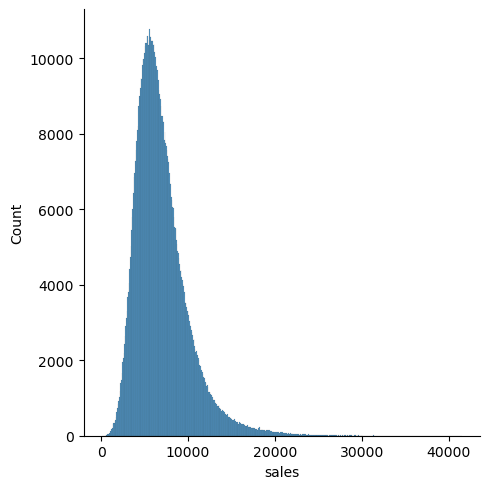

In [60]:
sns.displot(df4['sales'])

### 4.1.2 Numerical Variable

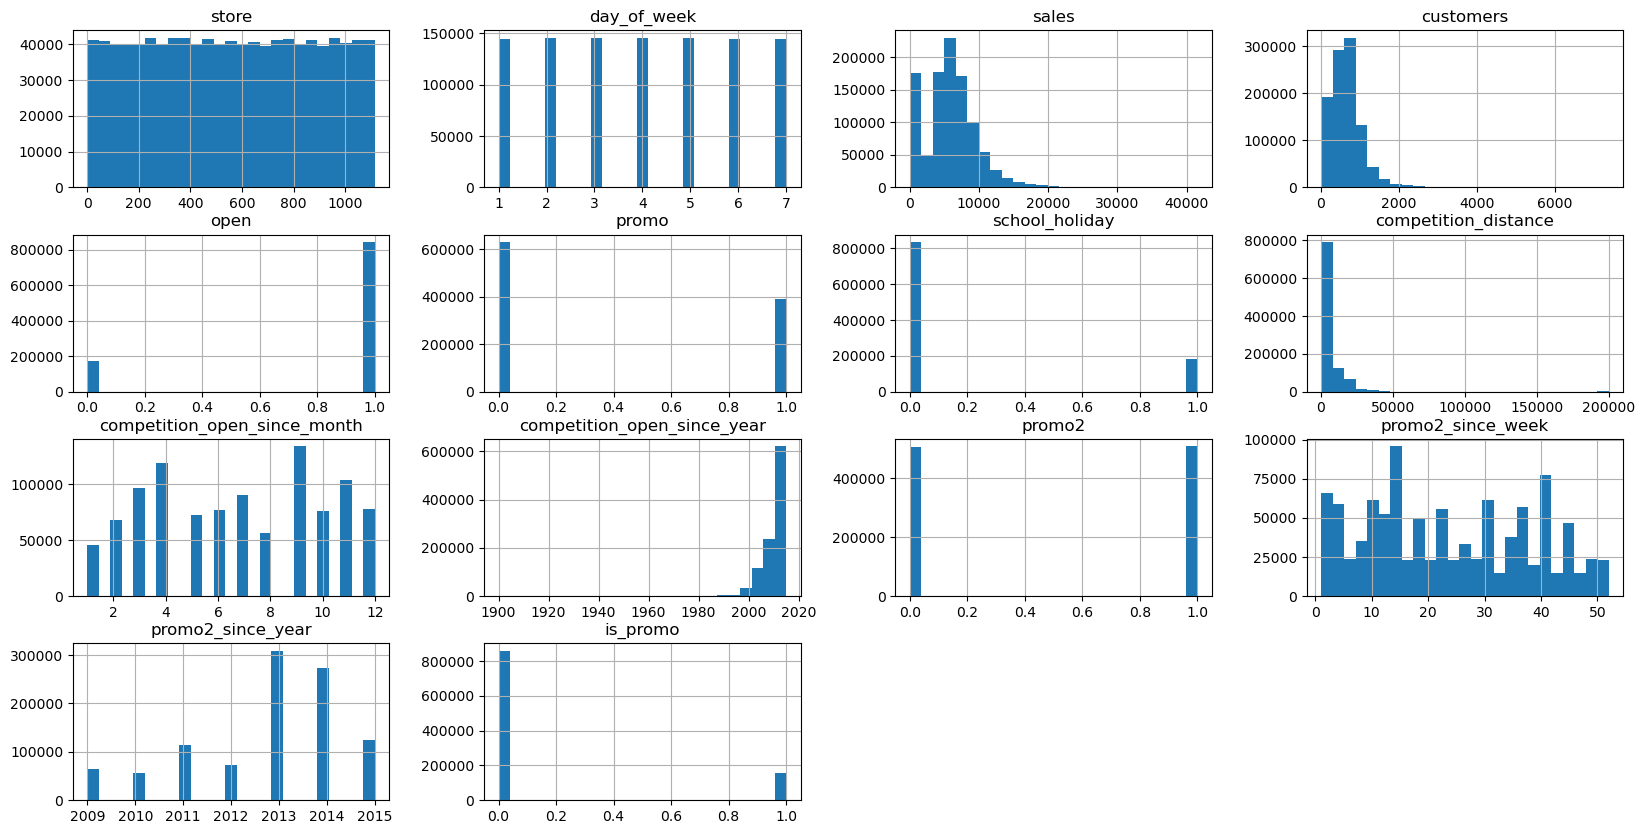

In [62]:
num_attributes.hist(bins = 25, figsize = (20, 10)); # ponto e vírgula para não mostrar mensagem

### 4.1.3 Categorical Variable

In [64]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\90913325.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = a['state_holiday'], palette ='viridis')
C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\90913325.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df4['store_type'], palette ='viridis')
C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\90913325.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df4['assortment'], palette ='viridis')


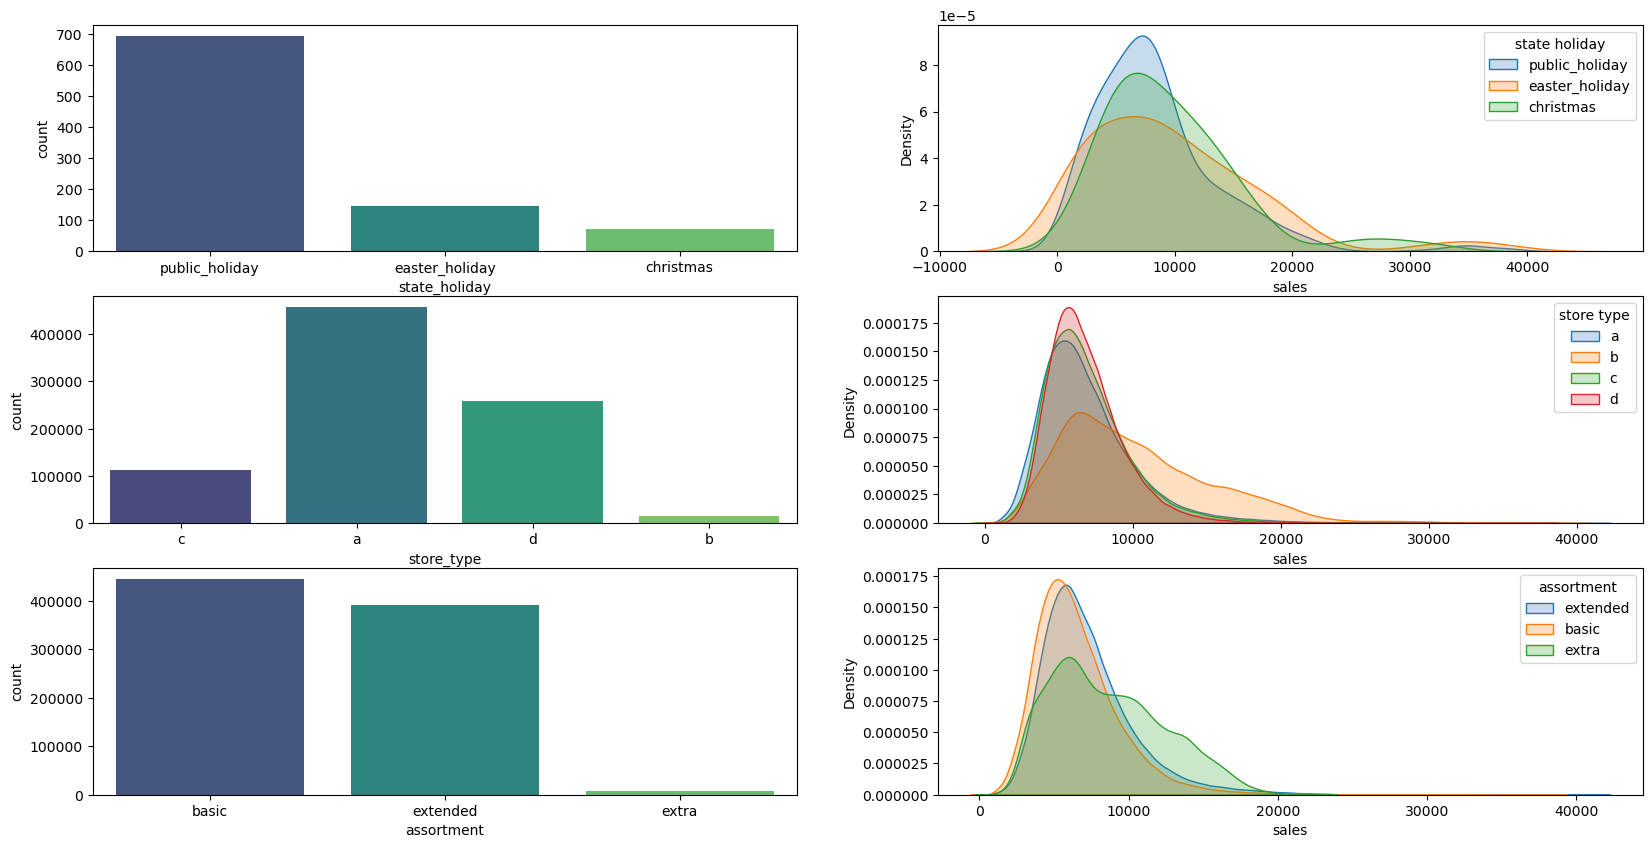

In [65]:
# state_holiday
plt.figure(figsize = (20, 10))
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x = a['state_holiday'], palette ='viridis')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',  fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True)
plt.legend(title='state holiday')

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x = df4['store_type'], palette ='viridis')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill = True)
plt.legend(title='store type')

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x = df4['assortment'], palette ='viridis')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill = True)
plt.legend(title='assortment')

## 4.2 Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSO!** Lojas com MAIOR SORTIMENTO vendem MENOS.

C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\3871963425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='assortment', y='sales', data=aux1, palette = 'viridis');


<Axes: xlabel='year_week'>

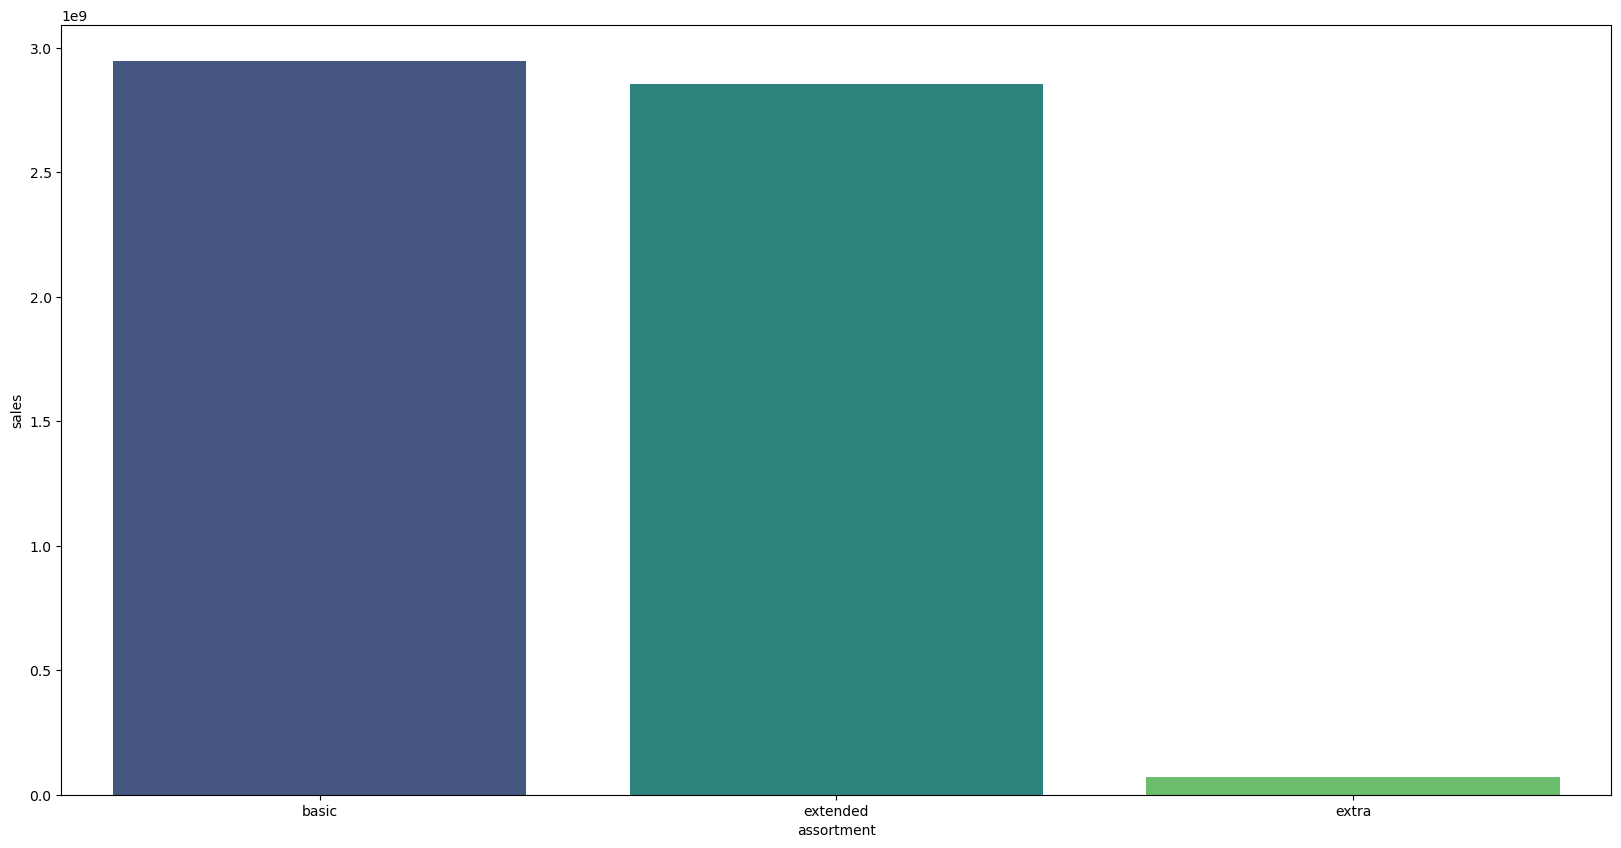

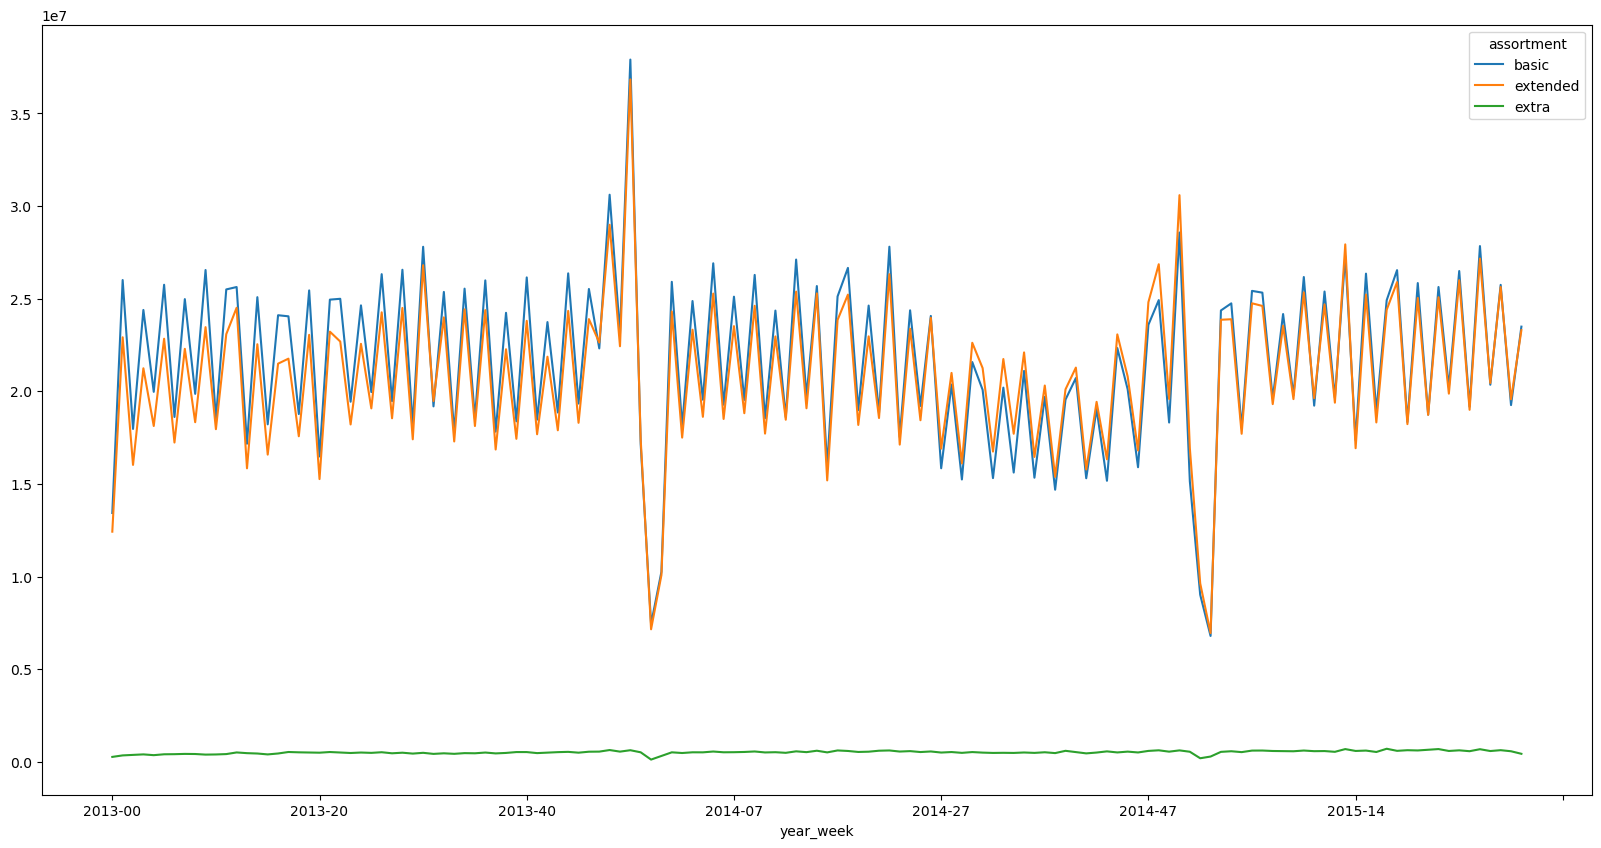

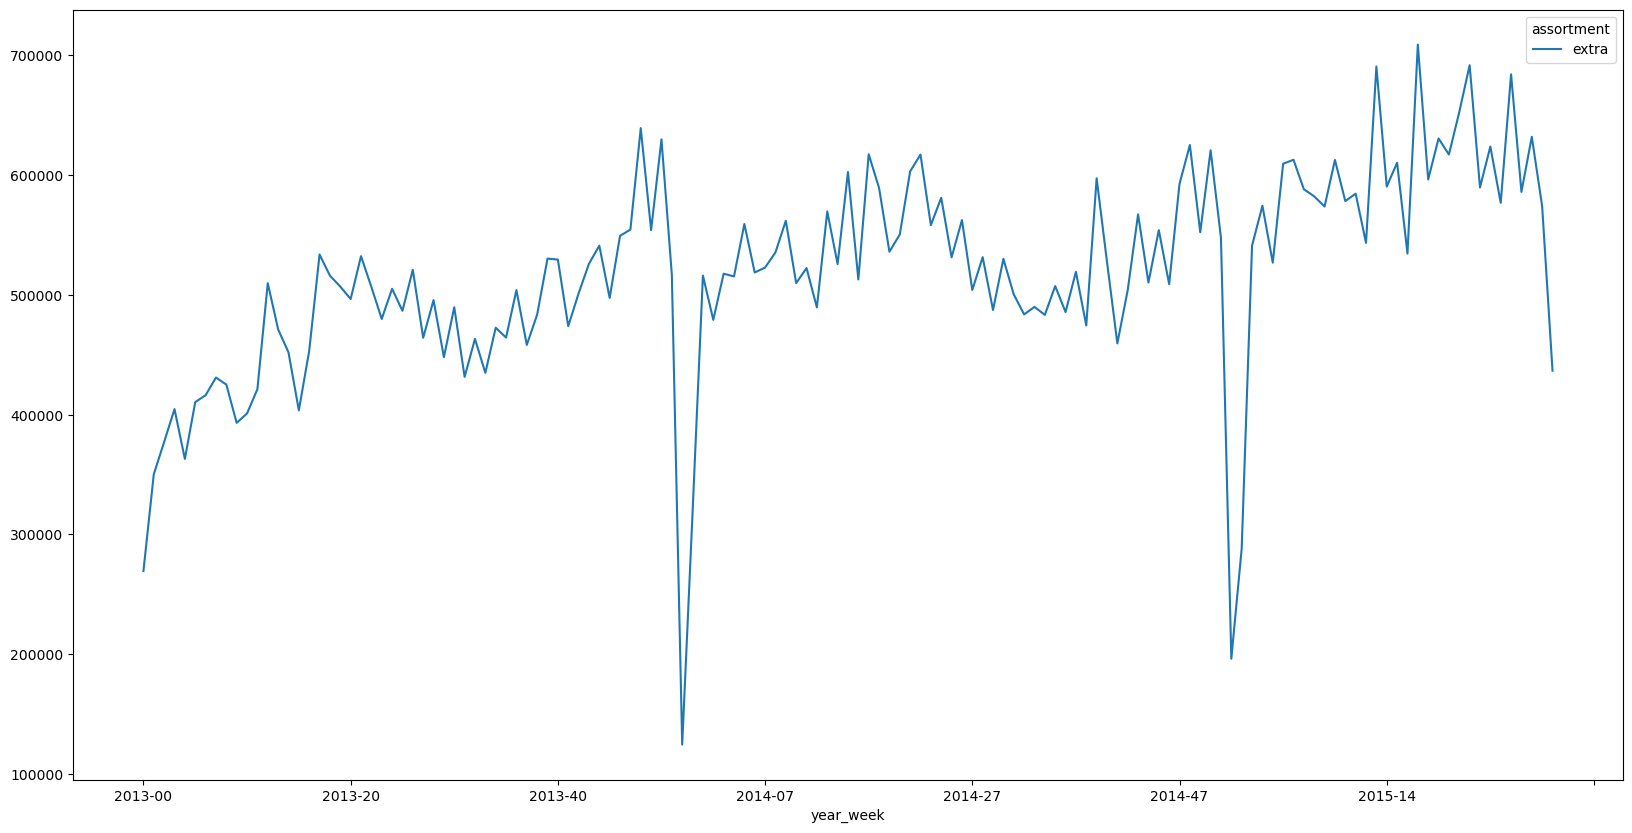

In [68]:
plt.figure(figsize=(20,10))
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, palette = 'viridis');

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20,10))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20,10))

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSO!** Lojas com competidores MAIS PRÓXIMOS vendem MAIS.

C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\475930538.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\475930538.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='competition_distance_binned', y='sales', data= aux2, palette = 'viridis')


<Axes: >

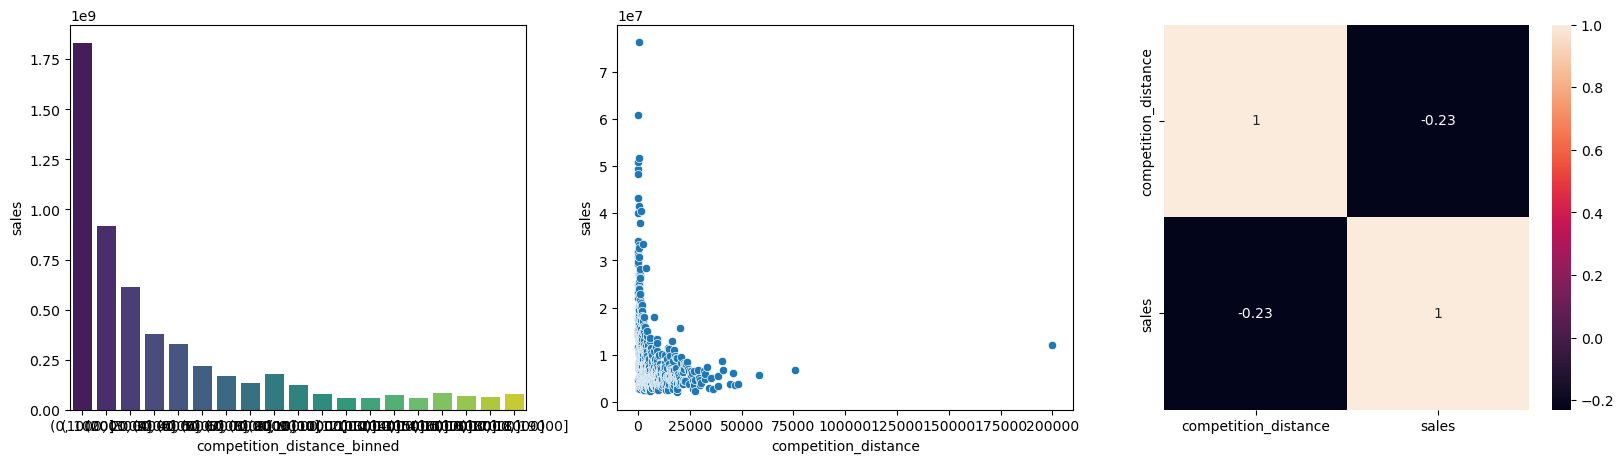

In [70]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(20,5))
bins = np.arange(0, 20000, 1000)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='competition_distance_binned', y='sales', data= aux2, palette = 'viridis')

plt.subplot(1, 3, 2)
sns.scatterplot(x='competition_distance', y='sales', data= aux1)

plt.subplot(1,3,3)
aux1 = aux1.drop(columns='competition_distance_binned')
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSO!** Lojas com COMPETIDORES à mais vendem MENOS. 

C:\Users\dmjes\AppData\Local\Temp\ipykernel_1224\1523144877.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='competition_time_month', y='sales', data=aux2, palette= 'viridis');


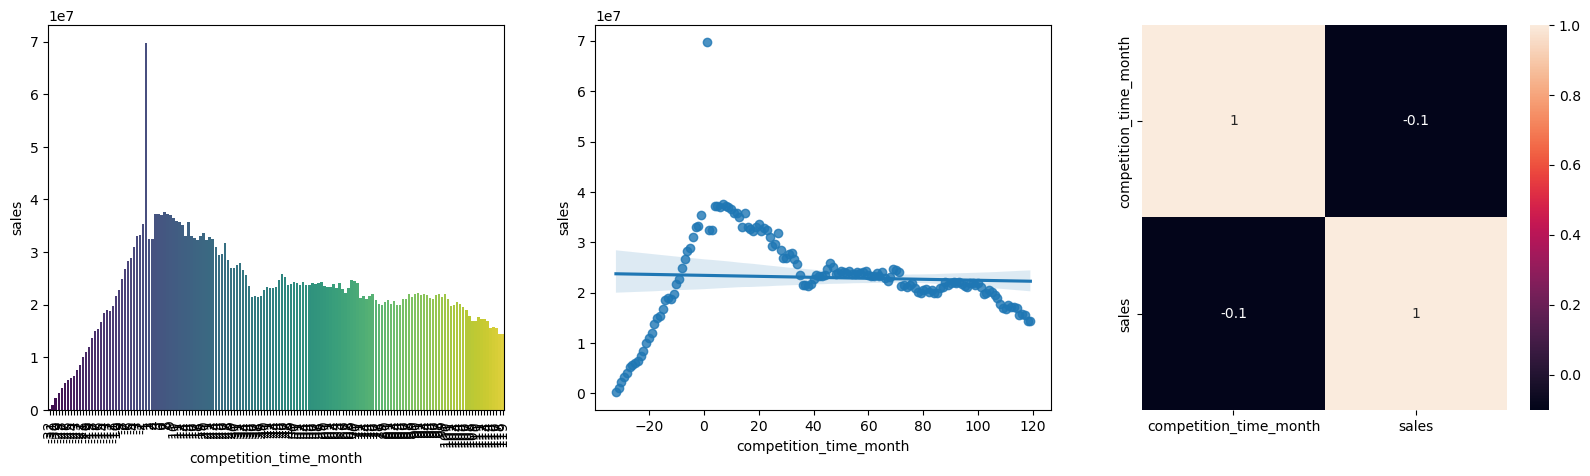

In [72]:
aux1= df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2= aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month'] != 0)]
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2, palette= 'viridis');
plt.xticks( rotation=90 );

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## 4.3 Analise Multivariada

### 4.3.2 Numerical Attributes

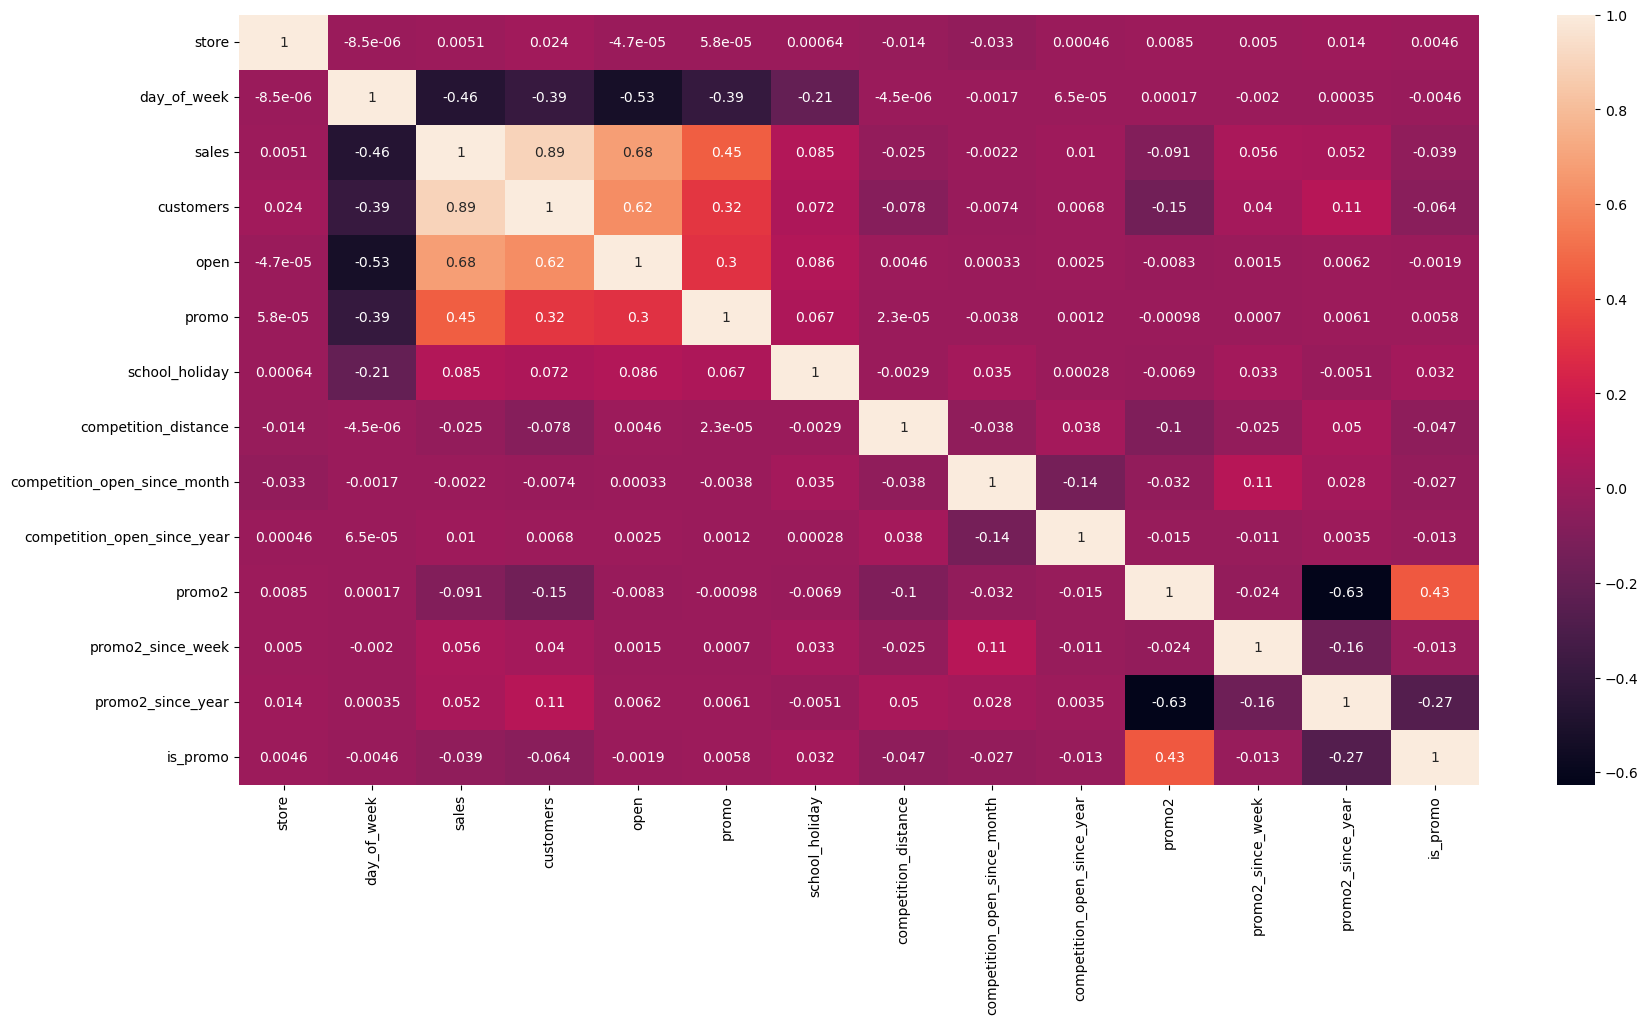

In [75]:
correlation= num_attributes.corr(method= 'pearson')
plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot= True);

### 4.3.2 Categorical Attributes

In [77]:
# Only categorical variables
a = df4.select_dtypes(include= 'object')

# Calculate Cramer V
a1= cramer_v(a['state_holiday'], a['state_holiday'])
a2= cramer_v(a['state_holiday'], a['store_type'])
a3= cramer_v(a['state_holiday'], a['assortment'])

a4= cramer_v(a['store_type'], a['state_holiday'])
a5= cramer_v(a['store_type'], a['store_type'])
a6= cramer_v(a['store_type'], a['assortment'])

a7= cramer_v(a['assortment'], a['state_holiday'])
a8= cramer_v(a['assortment'], a['store_type'])
a9= cramer_v(a['assortment'], a['assortment'])

# Final dataset
d= pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9] })
d= d.set_index(d.columns)

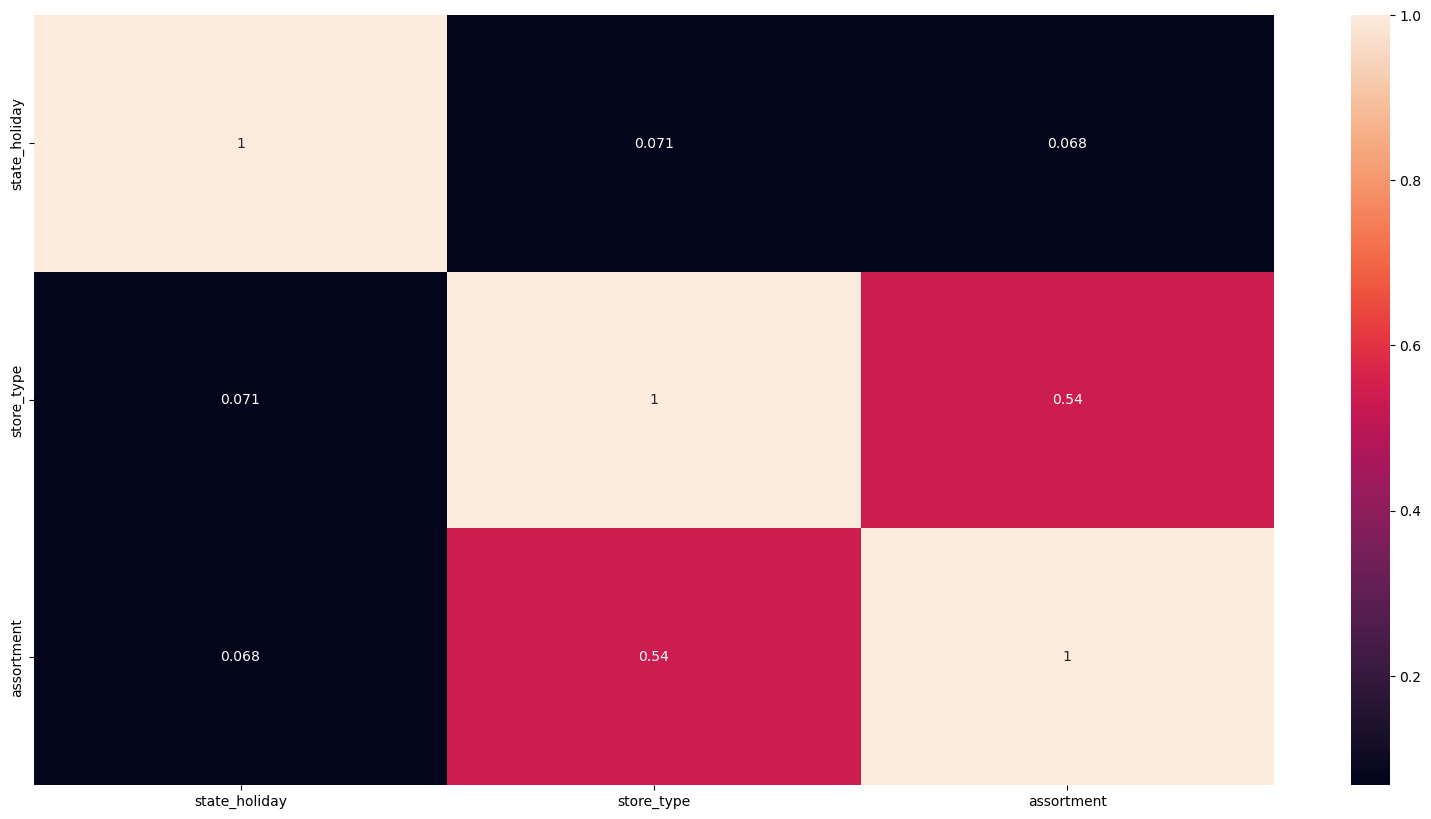

In [78]:
plt.figure(figsize= (20, 10))
sns.heatmap(d, annot= True);

# 5.0 Data Preparation

In [80]:
df5= df4.copy()

## 5.1 Normalização
**Verificando os gráficos da sessão 4.1.2 Numerical Variable, não foi vericado nehum gráfico com
distribuição normal, pode isso o método da normalização não será usado.**

## 5.2 Rescaling

In [83]:
rs= RobustScaler()
mms= MinMaxScaler()

# competition distance ## Os outliers são relevantes
df5['competition_distance']= rs.fit_transform(df5[['competition_distance']].values)

# competition time month  ## Os outliers são relevantes
df5['competition_time_month']= rs.fit_transform(df5[['competition_time_month']].values)

# promo time week  ## Os outliers NÃO são relevantes
df5['promo_time_week']= mms.fit_transform(df5[['promo_time_week']].values)

# year ## Os outliers NÃO são relevantes
df5['year']= mms.fit_transform(df5[['year']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [86]:
# state_holyday - one hot encoding(uma hora em estado de dias regulares, outras em páscoa e outras em natal)
df5= pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)
lista= ['state_holiday_easter_holiday',	'state_holiday_public_holiday',	'state_holiday_regular_day']

# store_type - label encoding(Não há ordem, hierarquia ou relação entre elas)
le= LabelEncoder()
df5['store_type']= le.fit_transform(df5['store_type'])

# assortment - ordinal encoding (basic < extra < extended; há hierarquia entre as variáveis)
assortment_dict= {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment']= df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation
**Deixar a variável resposta mais próxima da distribuição normal.**

In [88]:
df5['sales']= np.log1p(df5['sales'])

### 5.3.3 Nature Transformation
**Varíaveis cíclicas**

In [90]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2.*np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2.*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2.*np.pi/52)))

# 6.0 Feature Selection

In [92]:
df6= df5.copy()

## 6.1 Split dataframe into training and test dataset

In [94]:
cols_drop= ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6= df6.drop(cols_drop, axis=1)

É um dataset temporal, portanto as datas não podem ser coletadas aleatoriamente. Para o teste
foram selecionadas as linhas que corespondem as datas das 6 semanas mais recentes. Para o traino 
todo o dataset que sobou.

In [96]:
# Pegando a data 6 semanas antes da recente
# 6 semanas porque o previsão é de 6 semanas de venda
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [97]:
# training dataset
X_train= df6[df6['date']< '2015-06-19']
y_train= X_train['sales']

# test dataset
X_test= df6[df6['date']>= '2015-06-19']
y_test= X_test['sales']

#print(f'Train Min date: {X_train['date'].min()}')
#print(f'Train Max date: {X_train['date'].max()}')

#print(f'\nTest Min date: {X_test['date'].min()}')
#print(f'Test Max date: {X_test['date'].max()}')

## 6.2 Boruta as Feature selector

In [99]:
# training and test dataset for Boruta
#X_train_n= X_train.drop(['date', 'sales'], axis=1).values
#y_train_n= y_train.values.ravel()

# define RandomForestRegressor
#rf= RandomForestRegressor(n_jobs=-1)

# define boruta
#boruta= BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n )

### 6.2.1 Best Features from Boruta

In [101]:
#cols_selected= boruta.support_.tolist()

# best features
#X_train_fs= X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta= X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta= np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

In [102]:
#cols_selected_boruta

In [103]:
#cols_not_selected_boruta

In [104]:
cols_selected_boruta= [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_cos',
    'week_of_year_cos']

# columns to add
feat_to_add= ['date', 'sales']

# final features
#cols_selected_boruta.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [106]:
df7= df6.copy()

In [107]:
x_train= X_train[cols_selected_boruta]
x_test= X_test[cols_selected_boruta]

## 7.1 Avarage Model

In [110]:
aux1= x_test.copy()
#y_test= y_test.reset_index(drop=True)
aux1['sales']= y_test.copy()

# prediction
aux2= aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1=pd.merge(aux1, aux2, on='store', how='left')
yhat_baseline= aux1['predictions']

# performance
baseline_result= ml_error('Avarage Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [115]:
# model
lr= LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr= lr.predict(x_test)

#performance
lr_result= ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1870.572203,0.295041,2668.876826


## 7.3 Linear Regression Regularized Model - Lasso

In [121]:
# model
lrr= Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr= lrr.predict(x_test)

#performance
lrr_result= ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1891.194993,0.289872,2741.003248
